# Workbook for different transforms

This notebook is to try out different approaches to transforms that may, or may not, make any difference.

In [1]:
%load_ext autoreload
%autoreload 2

import hydra
from hydra.utils import get_original_cwd, instantiate

import logging
import os
import omegaconf
from omegaconf import DictConfig, ListConfig, OmegaConf

import pprint
import torch

from collections.abc import Sequence
from pathlib import Path
from typing import Any

from typing import Any
from builtins import dict, list, int
from collections import defaultdict

import pytorch_lightning as pl
import matplotlib.pyplot as plt

from emg2qwerty import transforms, utils
import emg2qwerty.lightning
import emg2qwerty.decoder
from emg2qwerty.transforms import Transform
import emg2qwerty.custom_transforms
from pytorch_wavelets import DWT1DForward
import torch.nn.functional as F


hydra.initialize(version_base=None, config_path='./config/')


hydra.initialize()

# Load config
Now that the libraries are all set, load the config.


In [3]:
config = hydra.compose(config_name='base', overrides=["user=single_user"])

print(OmegaConf.to_yaml(config.datamodule))

_target_: emg2qwerty.lightning.WindowedEMGDataModule
window_length: 8000
padding:
- 1800
- 200



# Load data
Instantiate the data loader

In [4]:
config.dataset.root = './data'
# Helper to instantiate full paths for dataset sessions
def _full_session_paths(dataset: ListConfig) -> list[Path]:
    sessions = [session["session"] for session in dataset]
    return [
        Path(config.dataset.root).joinpath(f"{session}.hdf5")
        for session in sessions
    ]

# Helper to instantiate transforms
def _build_transform(configs: Sequence[DictConfig]) -> Transform[Any, Any]:
    return transforms.Compose([instantiate(cfg) for cfg in configs])

datamodule = instantiate(
    config.datamodule,
    batch_size=config.batch_size,
    num_workers=config.num_workers,
    train_sessions=_full_session_paths(config.dataset.train),
    val_sessions=_full_session_paths(config.dataset.val),
    test_sessions=_full_session_paths(config.dataset.test),
    train_transform=_build_transform(config.transforms.train),
    val_transform=_build_transform(config.transforms.val),
    test_transform=_build_transform(config.transforms.test),
    _convert_="object",
)



In [5]:
print(_full_session_paths(config.dataset.train))
print(datamodule.train_sessions)
datamodule.setup()
#print(f'{str(datamodule)}')
loader = datamodule.train_dataloader()
print(f'{str(loader)}')
print(f'{len(loader)}')

[PosixPath('data/2021-06-03-1622765527-keystrokes-dca-study@1-0efbe614-9ae6-4131-9192-4398359b4f5f.hdf5'), PosixPath('data/2021-06-02-1622681518-keystrokes-dca-study@1-0efbe614-9ae6-4131-9192-4398359b4f5f.hdf5'), PosixPath('data/2021-06-04-1622863166-keystrokes-dca-study@1-0efbe614-9ae6-4131-9192-4398359b4f5f.hdf5'), PosixPath('data/2021-07-22-1627003020-keystrokes-dca-study@1-0efbe614-9ae6-4131-9192-4398359b4f5f.hdf5'), PosixPath('data/2021-07-21-1626916256-keystrokes-dca-study@1-0efbe614-9ae6-4131-9192-4398359b4f5f.hdf5'), PosixPath('data/2021-07-22-1627004019-keystrokes-dca-study@1-0efbe614-9ae6-4131-9192-4398359b4f5f.hdf5'), PosixPath('data/2021-06-05-1622885888-keystrokes-dca-study@1-0efbe614-9ae6-4131-9192-4398359b4f5f.hdf5'), PosixPath('data/2021-06-02-1622679967-keystrokes-dca-study@1-0efbe614-9ae6-4131-9192-4398359b4f5f.hdf5'), PosixPath('data/2021-06-03-1622764398-keystrokes-dca-study@1-0efbe614-9ae6-4131-9192-4398359b4f5f.hdf5'), PosixPath('data/2021-07-21-1626917264-keystro

Uh, ok, what's in it?

In [6]:
d = next(iter(loader))
print(f'{d["inputs"].shape}')

torch.Size([621, 32, 2, 16, 33])


# What this tensor means

Ok, so this actually makes sense.  The window size on the data, when read in, is 8000 points (4 seconds at 2khz). There is 1800 left and 200 right padding, so the window is 10,000 samples (5 seconds at 2khz). There are `batch_size` such windows in one "batch", so we would have a tensor that is `(10000, 32, 2, 16)`. However, when we do the FFT, the number of time points is down-sampled from 2khz to 125hz, because `hop_length=16` and $10000/16\approx 621$. And since `n_fft=64` we end with `n_fft//2+1=33` bins.

So, we have 32 batches of 621 time points sampled at 125hz or so, an a log spectrogram with 33 values, for each of the $2\times 16$ electrodes.

In [7]:

s = d['inputs'][:, 0, 0, 0, :].T


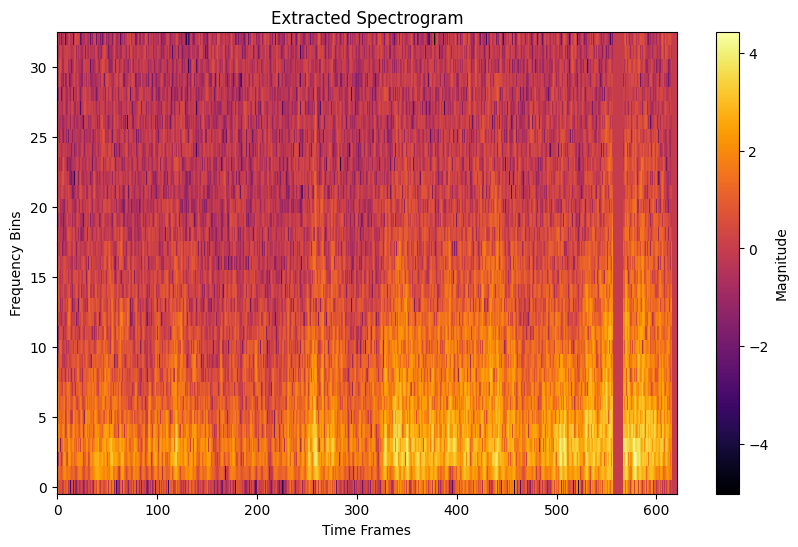

In [8]:


plt.figure(figsize=(10, 6))
plt.imshow(s.numpy(), aspect='auto', cmap='inferno', origin='lower')
plt.colorbar(label="Magnitude")
plt.xlabel("Time Frames")
plt.ylabel("Frequency Bins")
plt.title("Extracted Spectrogram")
plt.show()

# Loading the data without the spectrogram

Before we can write a decomposition, we need to get the data pre-FFT.  Set up a new configuration with overrides.

In [9]:
clean_config = hydra.compose(config_name='base', overrides=["transforms=investigation", "user=single_user"])

120
torch.Size([9995, 32, 2, 16])


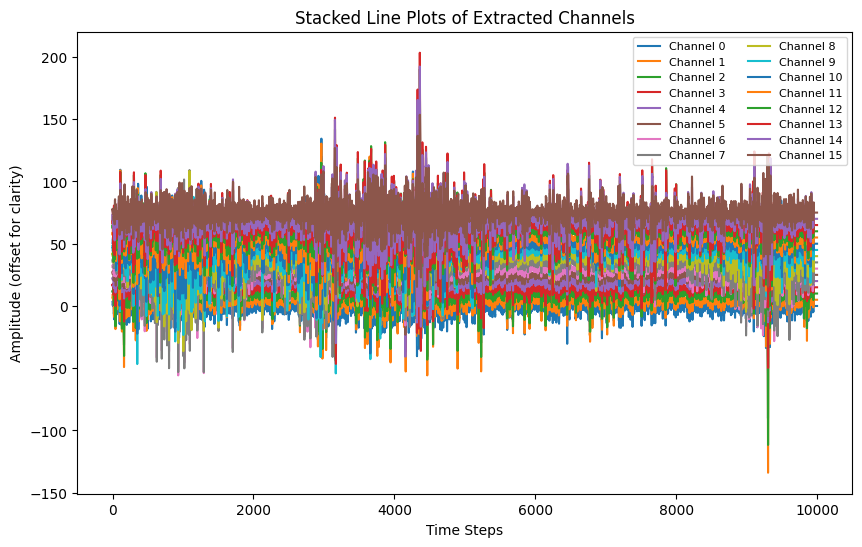

In [10]:

clean_datamodule = instantiate(
    clean_config.datamodule,
    batch_size=clean_config.batch_size,
    num_workers=clean_config.num_workers,
    train_sessions=_full_session_paths(clean_config.dataset.train),
    val_sessions=_full_session_paths(clean_config.dataset.val),
    test_sessions=_full_session_paths(clean_config.dataset.test),
    train_transform=_build_transform(clean_config.transforms.train),
    val_transform=_build_transform(clean_config.transforms.val),
    test_transform=_build_transform(clean_config.transforms.test),
    _convert_="object",
)

clean_datamodule.setup()
clean_loader = clean_datamodule.train_dataloader()
print(f'{str(clean_loader)}')
print(f'{len(clean_loader)}')

clean_d = next(iter(clean_loader))
print(f'{clean_d["inputs"].shape}')

# Extract the data to plot: shape (10000, 16)
data = clean_d["inputs"][:, 0, 0, :].numpy()

# Define the number of channels (last dimension)
num_channels = data.shape[1]

# Create a figure
plt.figure(figsize=(10, 6))

# Plot each channel with an offset
offset = 5  # Vertical spacing between lines
for i in range(num_channels):
    plt.plot(data[:, i] + i * offset, label=f"Channel {i}")

# Formatting
plt.xlabel("Time Steps")
plt.ylabel("Amplitude (offset for clarity)")
plt.title("Stacked Line Plots of Extracted Channels")
plt.legend(loc="upper right", fontsize=8, ncol=2)

# Sketch out a DWT

It's a little tricky because the DWT libraries are really not meant to be used on arbitrary tensors. They are somewhat vectorized, but we have to handle each of the bands individually.  So we basically do a 1d DWT on left, and one on right, and muck around with interpolation to get something that has the right dimensions as the fft scalogram, then we take the log and call it a day.  The results, well they don't look terrible tbh.

torch.Size([32, 2, 16, 9995])
Y1: torch.Size([32, 16, 5])
len(Yh): 11
left=torch.Size([621, 32, 16, 33])
Y1: torch.Size([32, 16, 5])
len(Yh): 11
Stacked=torch.Size([621, 32, 2, 16, 33])


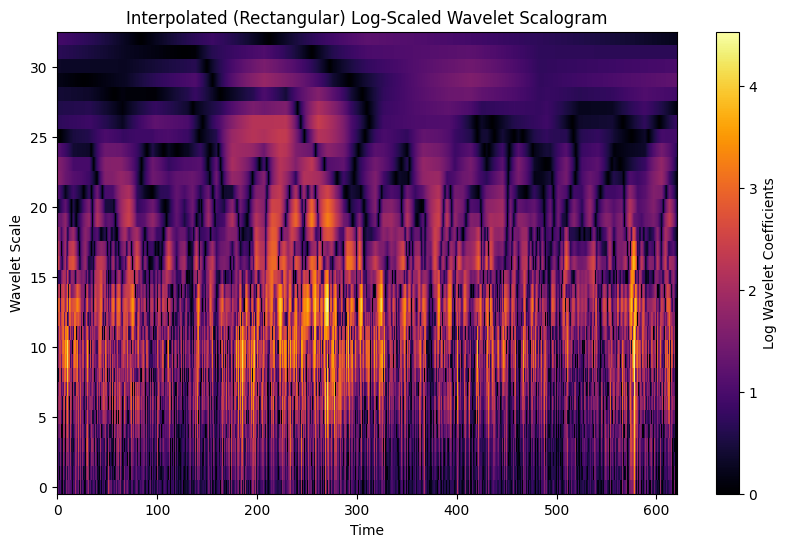

In [ ]:

tensor = clean_d['inputs']
swapped = tensor.movedim(0, -1)
print(f'{swapped.shape}')
dwt = DWT1DForward(J=11, wave='haar', mode='zero')

Y1, Yh = dwt(swapped[:,0,:,:])
print(f"Y1: {Y1.shape}")
print(f"len(Yh): {len(Yh)}")
stack = []
for i in range(len(Yh)):
    stack.append(F.interpolate(Yh[i], size=(621,), mode='linear', align_corners=True))
left_stacked = torch.stack(stack).movedim(-1, 0).movedim(1, -1)
left_stacked = F.interpolate(left_stacked, size=(16,33), mode='bilinear', align_corners=True)
print(f'left={left_stacked.shape}')

Y1, Yh = dwt(swapped[:,1,:,:])
print(f"Y1: {Y1.shape}")
print(f"len(Yh): {len(Yh)}")
stack = []
for i in range(len(Yh)):
    stack.append(F.interpolate(Yh[i], size=(621,), mode='linear', align_corners=True))
right_stacked = torch.stack(stack).movedim(-1, 0).movedim(1, -1)
right_stacked = F.interpolate(right_stacked, size=(16, 33), mode='bilinear', align_corners=True)

#stacked = F.interpolate(torch.stack([left_stacked, right_stacked], dim=2), size=33, mode='linear', align_corners=True)
stacked = torch.stack([left_stacked, right_stacked], dim=2)
print(f'Stacked={stacked.shape}')
scalogram_log = torch.log1p(torch.abs(stacked))

plt.figure(figsize=(10, 6))
plt.imshow(scalogram_log[:, 0, 0, 0, :].T.numpy(), aspect='auto', cmap='inferno', origin='lower')
plt.colorbar(label="Log Wavelet Coefficients")
plt.xlabel("Time")
plt.ylabel("Wavelet Scale")
plt.title("Interpolated (Rectangular) Log-Scaled Wavelet Scalogram")
plt.show()

plt.figure(figsize=(10, 6))
plt.imshow(scalogram_log[:, 0, 0, 0, :].T.numpy(), aspect='auto', cmap='inferno', origin='lower')
plt.colorbar(label="Non-log-scaled Wavelet Coefficients")
plt.xlabel("Time")
plt.ylabel("Wavelet Scale")
plt.title("Interpolated (Rectangular) Log-Scaled Wavelet Scalogram")
plt.show()

# Write it as a transform

So now we can write it as a transform in `custom_transforms.py` and apply it to a batch, then examine a few to see if there's much variation, compared to the variation in histograms.

In [36]:

custom_config = hydra.compose(config_name='base', overrides=["transforms=custom_transforms", "user=single_user"])

custom_datamodule = instantiate(
    custom_config.datamodule,
    batch_size=custom_config.batch_size,
    num_workers=custom_config.num_workers,
    train_sessions=_full_session_paths(custom_config.dataset.train),
    val_sessions=_full_session_paths(custom_config.dataset.val),
    test_sessions=_full_session_paths(custom_config.dataset.test),
    train_transform=_build_transform(custom_config.transforms.train),
    val_transform=_build_transform(custom_config.transforms.val),
    test_transform=_build_transform(custom_config.transforms.test),
    _convert_="object",
)

custom_datamodule.setup()
custom_loader = custom_datamodule.train_dataloader()
print(f'{str(custom_loader)}')
print(f'{len(custom_loader)}')

custom_d = next(iter(custom_loader))
print(f'{custom_d["inputs"].shape}')



120
torch.Size([622, 32, 2, 16, 33])


# Plot it
Moment of truth: let's take a look at the plot.

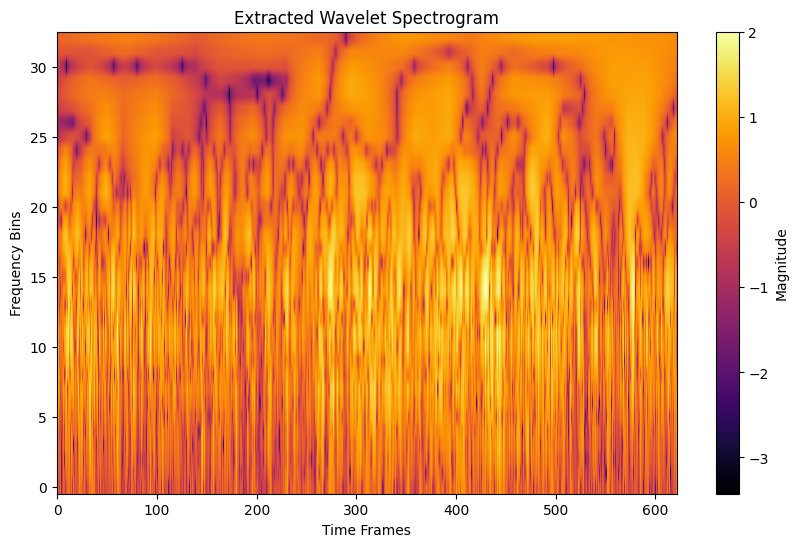

In [40]:
custom_s = custom_d['inputs'][:, 3, 0, 0, :].T

plt.figure(figsize=(10, 6))
plt.imshow(custom_s.numpy(), aspect='auto', cmap='inferno', origin='lower')
plt.colorbar(label="Magnitude")
plt.xlabel("Time Frames")
plt.ylabel("Frequency Bins")
plt.title("Extracted Wavelet Spectrogram")
plt.show()